# Heart Disease Tabular Benchmark — (Fixed) Logistic Regression, Random Forest, XGBoost, TabNet*, FT-Transformer* (+ Ensemble)
*Updated on 2025-09-06 02:51 UTC to fix package versions on Kaggle.*

- Robust installers (won't force CPU Torch on GPU; versions compatible with Kaggle).
- Graceful fallbacks if **TabNet** or **FT-Transformer** packages are unavailable.
- Everything else unchanged: preprocessing variants, CV metrics, XGBoost native missing, ensemble, SHAP (optional).

## Data Loader (Auto-pick largest heart/cardio file in `../input`)

Notebook đã được chỉnh để tự:
- Quét tất cả file trong `../input` có từ khóa: `cardio`, `cardiovascular`, `heart`, `framingham`.
- Hỗ trợ `.csv / .tsv / .parquet` và các delimiter phổ biến (`,` `\t` `;` `|`).
- Chọn **file có số dòng lớn nhất**.
- Chuẩn hóa tên cột nhãn → `target` (ưu tiên các tên: `target`, `output`, `cardio`, `TenYearCHD`, ...).

In [9]:
# ==== LOAD CARDIOVASCULAR DATA (70k) ====
import pandas as pd
import numpy as np

data_path = "../input/cardio-train-70000/cardio_train.csv"  # đường dẫn đúng file Kaggle của bạn

# Đọc CSV với delimiter = ";"
df_raw = pd.read_csv(data_path, sep=";")

# Chuẩn hoá cột nhãn về 'target'
if "cardio" not in df_raw.columns:
    raise ValueError("Không thấy cột 'cardio' trong file. Kiểm tra lại tên cột.")
df_raw = df_raw.rename(columns={"cardio": "target"}).copy()

print("✅ Loaded:", data_path, "| shape =", df_raw.shape)
display(df_raw.head())
print(df_raw.isna().sum().sort_values(ascending=False).head(12))


✅ Loaded: ../input/cardio-train-70000/cardio_train.csv | shape = (70000, 13)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,target
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
dtype: int64


## Preprocessing cho Cardiovascular (age_years, BMI, lọc outliers, encode & scale)

- Lọc các ngoại lai không hợp lý: `ap_hi`, `ap_lo`, `height`, `weight`.
- Tạo `age_years`, `bmi`, `bp_diff`.
- Chuẩn hóa `gender` thành nhị phân (0=female,1=male) nếu ở dạng 1/2.
- Xử lý missing:
  - Numeric: **mean** + **MissingIndicator** (giữ tín hiệu thiếu).
  - Categorical: **'Missing'** category (OneHot).
- **Scaling** chỉ áp cho LR/DL; RF/XGB không cần.

In [10]:
import numpy as np, pandas as pd
df = df_raw.copy()

bounds = {"ap_hi": (80, 250), "ap_lo": (40, 180), "height": (120, 220), "weight": (30, 200)}
for col, (lo, hi) in bounds.items():
    if col in df.columns:
        df = df[(df[col] > lo) & (df[col] < hi)]

if "age" in df.columns:
    df["age_years"] = (df["age"] // 365).astype(int)
if set(["height","weight"]).issubset(df.columns):
    df["bmi"] = df["weight"] / (df["height"]/100.0)**2
if set(["ap_hi","ap_lo"]).issubset(df.columns):
    df["bp_diff"] = df["ap_hi"] - df["ap_lo"]

if "gender" in df.columns:
    df["gender_bin"] = df["gender"].replace({1:0, 2:1}).fillna(df["gender"])

y = df["target"].astype(int).copy()
X = df.drop(columns=["target", "id"], errors="ignore").copy()

cat_candidates = set(["cholesterol","gluc","smoke","alco","active","gender","gender_bin"])
cat_cols = [c for c in X.columns if c in cat_candidates or X[c].dtype == "object"]
num_cols = [c for c in X.columns if c not in cat_cols]

print("Numeric cols (sample):", num_cols[:12])
print("Categorical cols:", cat_cols)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer, MissingIndicator

simple_num = Pipeline([("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler())])
simple_cat = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")), ("ohe", OneHotEncoder(handle_unknown="ignore"))])
preproc_simple = ColumnTransformer([("num", simple_num, num_cols), ("cat", simple_cat, cat_cols)])

missing_num = Pipeline([("imputer", SimpleImputer(strategy="mean"))])
missing_cat = Pipeline([("imputer", SimpleImputer(strategy="constant", fill_value="Missing")), ("ohe", OneHotEncoder(handle_unknown="ignore"))])
preproc_missingaware = ColumnTransformer([
    ("num", missing_num, num_cols),
    ("num_mi", MissingIndicator(features="missing-only"), num_cols),
    ("cat", missing_cat, cat_cols),
])

print("✅ Pipelines ready: preproc_simple, preproc_missingaware; and splits X_train/X_test/y_train/y_test")

Numeric cols (sample): ['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'age_years', 'bmi', 'bp_diff']
Categorical cols: ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'gender_bin']
✅ Pipelines ready: preproc_simple, preproc_missingaware; and splits X_train/X_test/y_train/y_test


## 1) Robust setup (auto-detect GPU, tolerant installs)

In [11]:
# Detect GPU and install only what is missing. Use versions that exist on PyPI/Kaggle.
import subprocess, sys, importlib, pkgutil, os, warnings
warnings.filterwarnings("ignore")

def pip_install(pkg):
    print(f"Installing: {pkg}")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

# Core libs
if importlib.util.find_spec("xgboost") is None:
    pip_install("xgboost==2.0.3")

# Try TabNet (optional)
HAS_TABNET = True
try:
    import pytorch_tabnet  # type: ignore
except Exception:
    try:
        pip_install("pytorch-tabnet==4.1.0")
        import pytorch_tabnet  # retry
    except Exception as e:
        print("TabNet unavailable:", e)
        HAS_TABNET = False

# Try FT-Transformer (optional) — use versions that exist
HAS_FTT = True
try:
    import tab_transformer_pytorch  # type: ignore
except Exception:
    try:
        # Pick a published version (see error list you got). 0.4.2 is available.
        pip_install("tab-transformer-pytorch==0.4.2")
        import tab_transformer_pytorch  # retry
    except Exception as e:
        print("FT-Transformer unavailable:", e)
        HAS_FTT = False

# SHAP (optional)
HAS_SHAP = True
try:
    import shap  # type: ignore
except Exception:
    try:
        pip_install("shap==0.46.0")
        import shap
    except Exception as e:
        print("SHAP unavailable:", e)
        HAS_SHAP = False

import numpy as np, pandas as pd, random, time, math
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

import torch
print("Torch:", torch.__version__, "| CUDA available:", torch.cuda.is_available())
print("xgboost:", xgb.__version__)
try:
    import pytorch_tabnet
    print("pytorch_tabnet:", pytorch_tabnet.__version__)
except Exception:
    pass
try:
    import tab_transformer_pytorch
    print("tab_transformer_pytorch:", tab_transformer_pytorch.__version__)
except Exception:
    pass
try:
    import shap
    print("shap:", shap.__version__)
except Exception:
    pass

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE); random.seed(RANDOM_STATE); torch.manual_seed(RANDOM_STATE)

Installing: pytorch-tabnet==4.1.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.7 MB/s eta 0:00:00
Installing: tab-transformer-pytorch==0.4.2
Torch: 2.6.0+cu124 | CUDA available: True
xgboos

## 2) Load data (multiple mirrors; attach if needed)

In [13]:
import pandas as pd
import numpy as np

data_path = "/kaggle/input/cardio-train-70000/cardio_train.csv"
df = pd.read_csv(data_path, sep=";")   # nhớ sep=";"

# Chuẩn hóa nhãn: cột 'cardio' → 'target'
df = df.rename(columns={"cardio": "target"})

target_col = "target"
print("Target:", target_col)
display(df.head())
print(df.isna().sum().sort_values(ascending=False).head(10))


Target: target


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,target
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
dtype: int64


## 3) Split & feature typing

In [14]:
X = df.drop(columns=[target_col]).copy()
y = df[target_col].astype(int).copy()

cat_cols = [c for c in X.columns if X[c].dtype == 'object' or str(X[c].dtype).startswith('category')]
num_cols = [c for c in X.columns if c not in cat_cols]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print("Numeric:", len(num_cols), "| Categorical:", len(cat_cols))
print("Train:", X_train.shape, "Test:", X_test.shape)

Numeric: 12 | Categorical: 0
Train: (56000, 12) Test: (14000, 12)


## 4) Preprocessing A: simple vs B: missing-aware

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, MissingIndicator

simple_num = Pipeline([("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler())])
simple_cat = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")), ("ohe", OneHotEncoder(handle_unknown="ignore"))])
preproc_simple = ColumnTransformer([("num", simple_num, num_cols), ("cat", simple_cat, cat_cols)])

missing_num = Pipeline([("imputer", SimpleImputer(strategy="mean"))])  # + indicator
missing_cat = Pipeline([("imputer", SimpleImputer(strategy="constant", fill_value="Missing")), ("ohe", OneHotEncoder(handle_unknown="ignore"))])
preproc_missingaware = ColumnTransformer([
    ("num", missing_num, num_cols),
    ("num_mi", MissingIndicator(features="missing-only"), num_cols),
    ("cat", missing_cat, cat_cols),
])

## 5) CV helper

In [16]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, accuracy_score
import numpy as np, time

def evaluate_model(name, pipeline, X, y, cv=5):
    scoring = {"roc_auc": "roc_auc", "pr_auc": "average_precision", "f1": "f1", "accuracy": "accuracy"}
    t0 = time.perf_counter()
    cvres = cross_validate(pipeline, X, y,
        cv=StratifiedKFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE),
        scoring=scoring, n_jobs=-1, return_train_score=False)
    dt = time.perf_counter() - t0
    return {"Model": name,
            "ROC-AUC": np.mean(cvres["test_roc_auc"]),
            "PR-AUC": np.mean(cvres["test_pr_auc"]),
            "F1": np.mean(cvres["test_f1"]),
            "Accuracy": np.mean(cvres["test_accuracy"]),
            "Train time (s)": dt}

## 6) Classic models — LR, RF, DT, XGBoost

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import pandas as pd

results = []

lr = Pipeline([("pre", preproc_simple),
               ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))])
results.append(evaluate_model("Logistic Regression (simple)", lr, X_train, y_train))

rf_simple = Pipeline([("pre", preproc_simple),
                      ("clf", RandomForestClassifier(n_estimators=400, random_state=RANDOM_STATE, class_weight="balanced"))])
results.append(evaluate_model("Random Forest (simple)", rf_simple, X_train, y_train))

rf_missing = Pipeline([("pre", preproc_missingaware),
                       ("clf", RandomForestClassifier(n_estimators=400, random_state=RANDOM_STATE, class_weight="balanced"))])
results.append(evaluate_model("Random Forest (missing-aware)", rf_missing, X_train, y_train))

dt_simple = Pipeline([("pre", preproc_simple),
                      ("clf", DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight="balanced"))])
results.append(evaluate_model("Decision Tree (simple)", dt_simple, X_train, y_train))

dt_missing = Pipeline([("pre", preproc_missingaware),
                       ("clf", DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight="balanced"))])
results.append(evaluate_model("Decision Tree (missing-aware)", dt_missing, X_train, y_train))

# XGBoost with native missing for numeric; OHE for categoricals
if len(cat_cols):
    preproc_xgb = ColumnTransformer([("num", "passthrough", num_cols),
                                     ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)])
else:
    preproc_xgb = "passthrough"

xgb_clf = Pipeline([("pre", preproc_xgb),
                    ("clf", xgb.XGBClassifier(
                        n_estimators=500, max_depth=5, learning_rate=0.05,
                        subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
                        random_state=RANDOM_STATE, tree_method="hist", eval_metric="logloss"
                    ))])
results.append(evaluate_model("XGBoost (native missing)", xgb_clf, X_train, y_train))

pd.DataFrame(results)

,Model,ROC-AUC,PR-AUC,F1,Accuracy,Train time (s)
0,Logistic Regression (simple),0.782799,0.762794,0.707786,0.719589,2.247108
1,Random Forest (simple),0.789427,0.773056,0.719631,0.727018,73.232932
2,Random Forest (missing-aware),0.789390,0.773065,0.719417,0.726839,72.294958
3,Decision Tree (simple),0.635321,0.585708,0.634984,0.635321,1.777848
4,Decision Tree (missing-aware),0.635625,0.585934,0.635360,0.635625,1.195240
5,XGBoost (native missing),0.801193,0.784169,0.724337,0.735429,5.025202


## 7) TabNet (optional, skipped if not available)

In [18]:
import pandas as pd, numpy as np, time
res_tabnet = None

if "HAS_TABNET" in globals() and HAS_TABNET:
    try:
        from sklearn.preprocessing import OneHotEncoder
        from pytorch_tabnet.tab_model import TabNetClassifier

        ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)
        if len(cat_cols):
            X_train_ohe = ohe.fit_transform(X_train.fillna("Missing"))
            X_test_ohe  = ohe.transform(X_test.fillna("Missing"))
        else:
            X_train_ohe = X_train.fillna(X_train.mean()).to_numpy()
            X_test_ohe  = X_test.fillna(X_train.mean()).to_numpy()

        tabnet = TabNetClassifier(n_d=16, n_a=16, n_steps=4, gamma=1.5, n_independent=2, n_shared=2,
                                  momentum=0.3, lambda_sparse=1e-4, seed=RANDOM_STATE)
        t0 = time.perf_counter()
        tabnet.fit(X_train_ohe, y_train.values,
                   eval_set=[(X_test_ohe, y_test.values)], eval_metric=['auc'],
                   max_epochs=100, patience=20, batch_size=512, virtual_batch_size=128)
        tabnet_time = time.perf_counter() - t0

        pred_proba = tabnet.predict_proba(X_test_ohe)[:,1]
        pred_label = (pred_proba >= 0.5).astype(int)
        from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, accuracy_score
        res_tabnet = {"Model": "TabNet (OHE)",
                      "ROC-AUC": roc_auc_score(y_test, pred_proba),
                      "PR-AUC": average_precision_score(y_test, pred_proba),
                      "F1": f1_score(y_test, pred_label),
                      "Accuracy": accuracy_score(y_test, pred_label),
                      "Train time (s)": tabnet_time}
        res_tabnet
    except Exception as e:
        print("TabNet run failed:", e)
else:
    print("TabNet not installed; skipping.")

epoch 0  | loss: 0.62551 | val_0_auc: 0.70407 |  0:00:05s
epoch 1  | loss: 0.57607 | val_0_auc: 0.73135 |  0:00:09s
epoch 2  | loss: 0.56526 | val_0_auc: 0.75874 |  0:00:13s
epoch 3  | loss: 0.5593  | val_0_auc: 0.73338 |  0:00:17s
epoch 4  | loss: 0.55917 | val_0_auc: 0.73971 |  0:00:22s
epoch 5  | loss: 0.55907 | val_0_auc: 0.71963 |  0:00:26s
epoch 6  | loss: 0.55739 | val_0_auc: 0.73003 |  0:00:30s
epoch 7  | loss: 0.56036 | val_0_auc: 0.7354  |  0:00:34s
epoch 8  | loss: 0.5557  | val_0_auc: 0.76569 |  0:00:38s
epoch 9  | loss: 0.55353 | val_0_auc: 0.77709 |  0:00:42s
epoch 10 | loss: 0.5515  | val_0_auc: 0.77781 |  0:00:47s
epoch 11 | loss: 0.5525  | val_0_auc: 0.75977 |  0:00:51s
epoch 12 | loss: 0.55008 | val_0_auc: 0.75152 |  0:00:55s
epoch 13 | loss: 0.54919 | val_0_auc: 0.75617 |  0:00:59s
epoch 14 | loss: 0.54999 | val_0_auc: 0.76537 |  0:01:03s
epoch 15 | loss: 0.55247 | val_0_auc: 0.76303 |  0:01:08s
epoch 16 | loss: 0.55192 | val_0_auc: 0.74678 |  0:01:12s
epoch 17 | los

## 8) FT-Transformer (optional, skipped if not available)

In [19]:
import time, numpy as np, pandas as pd
res_ft = None

if "HAS_FTT" in globals() and HAS_FTT:
    try:
        import torch
        from torch.utils.data import Dataset, DataLoader
        import torch.nn as nn
        from tab_transformer_pytorch import FTTransformer

        from sklearn.preprocessing import OneHotEncoder
        ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)
        if len(cat_cols):
            X_train_ohe = ohe.fit_transform(X_train.fillna("Missing"))
            X_test_ohe  = ohe.transform(X_test.fillna("Missing"))
        else:
            X_train_ohe = X_train.fillna(X_train.mean()).to_numpy()
            X_test_ohe  = X_test.fillna(X_train.mean()).to_numpy()

        class NpDataset(Dataset):
            def __init__(self, X, y):
                import torch
                self.X = torch.tensor(X, dtype=torch.float32)
                self.y = torch.tensor(y.values if isinstance(y, pd.Series) else y, dtype=torch.long)
            def __len__(self): return self.X.shape[0]
            def __getitem__(self, idx): return self.X[idx], self.y[idx]

        train_ds = NpDataset(X_train_ohe, y_train)
        test_ds  = NpDataset(X_test_ohe, y_test)
        train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
        test_loader  = DataLoader(test_ds, batch_size=256, shuffle=False)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = FTTransformer(categories=(),
                              num_continuous=X_train_ohe.shape[1],
                              dim=64, dim_head=32, depth=2, heads=4,
                              attn_dropout=0.1, ff_dropout=0.1,
                              mlp_hidden_mults=(2,), num_special_tokens=0,
                              continuous_mean_std=None, out_dim=2).to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)

        def train_ft(model, loader, epochs=12):
            model.train()
            for ep in range(epochs):
                total = 0.0
                for xb, yb in loader:
                    xb, yb = xb.to(device), yb.to(device)
                    optimizer.zero_grad()
                    logits = model(xb)
                    loss = criterion(logits, yb)
                    loss.backward()
                    optimizer.step()
                    total += loss.item()*xb.size(0)
                print(f"Epoch {ep+1}/{epochs} - loss {total/len(loader.dataset):.4f}")

        t0 = time.perf_counter()
        train_ft(model, train_loader, epochs=12)
        ft_time = time.perf_counter() - t0

        model.eval()
        probs, labels = [], []
        with torch.no_grad():
            for xb, yb in test_loader:
                xb = xb.to(device)
                logits = model(xb)
                p = torch.softmax(logits, dim=1)[:,1].cpu().numpy()
                probs.append(p); labels.append(yb.numpy())
        pred_proba = np.concatenate(probs); ytrue = np.concatenate(labels)
        pred_label = (pred_proba >= 0.5).astype(int)

        from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, accuracy_score
        res_ft = {"Model": "FT-Transformer (OHE, small)",
                  "ROC-AUC": roc_auc_score(ytrue, pred_proba),
                  "PR-AUC": average_precision_score(ytrue, pred_proba),
                  "F1": f1_score(ytrue, pred_label),
                  "Accuracy": accuracy_score(ytrue, pred_label),
                  "Train time (s)": ft_time}
        res_ft
    except Exception as e:
        print("FT-Transformer run failed:", e)
else:
    print("FT-Transformer not installed; skipping.")

FT-Transformer run failed: FTTransformer.__init__() got an unexpected keyword argument 'mlp_hidden_mults'


## 9) Aggregate results + Ensemble

In [20]:
import pandas as pd, numpy as np, time
from sklearn.ensemble import VotingClassifier

all_res = pd.DataFrame(results)
if 'res_tabnet' in globals() and res_tabnet is not None:
    all_res = pd.concat([all_res, pd.DataFrame([res_tabnet])], ignore_index=True)
if 'res_ft' in globals() and res_ft is not None:
    all_res = pd.concat([all_res, pd.DataFrame([res_ft])], ignore_index=True)

# Fit ensemble on full train
lr.fit(X_train, y_train)
rf_missing.fit(X_train, y_train)
xgb_clf.fit(X_train, y_train)

voter = VotingClassifier(estimators=[("lr", lr), ("rf", rf_missing), ("xgb", xgb_clf)], voting="soft")
t0 = time.perf_counter(); voter.fit(X_train, y_train); ens_time = time.perf_counter() - t0

pred = voter.predict(X_test); proba = voter.predict_proba(X_test)[:,1]
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, accuracy_score
res_ens = {"Model": "Voting Ensemble (LR + RF(missing) + XGB)",
           "ROC-AUC": roc_auc_score(y_test, proba),
           "PR-AUC": average_precision_score(y_test, proba),
           "F1": f1_score(y_test, pred),
           "Accuracy": accuracy_score(y_test, pred),
           "Train time (s)": ens_time}

final_table = pd.concat([all_res, pd.DataFrame([res_ens])], ignore_index=True)
final_table.sort_values("ROC-AUC", ascending=False).reset_index(drop=True)

,Model,ROC-AUC,PR-AUC,F1,Accuracy,Train time (s)
0,XGBoost (native missing),0.801193,0.784169,0.724337,0.735429,5.025202
1,Voting Ensemble (LR + RF(missing) + XGB),0.796717,0.777766,0.721406,0.730500,34.947174
2,Random Forest (simple),0.789427,0.773056,0.719631,0.727018,73.232932
3,Random Forest (missing-aware),0.789390,0.773065,0.719417,0.726839,72.294958
4,Logistic Regression (simple),0.782799,0.762794,0.707786,0.719589,2.247108
5,TabNet (OHE),0.779604,0.756955,0.685262,0.713071,170.451667
6,Decision Tree (missing-aware),0.635625,0.585934,0.635360,0.635625,1.195240
7,Decision Tree (simple),0.635321,0.585708,0.634984,0.635321,1.777848


## 10) SHAP on best tree model (optional)

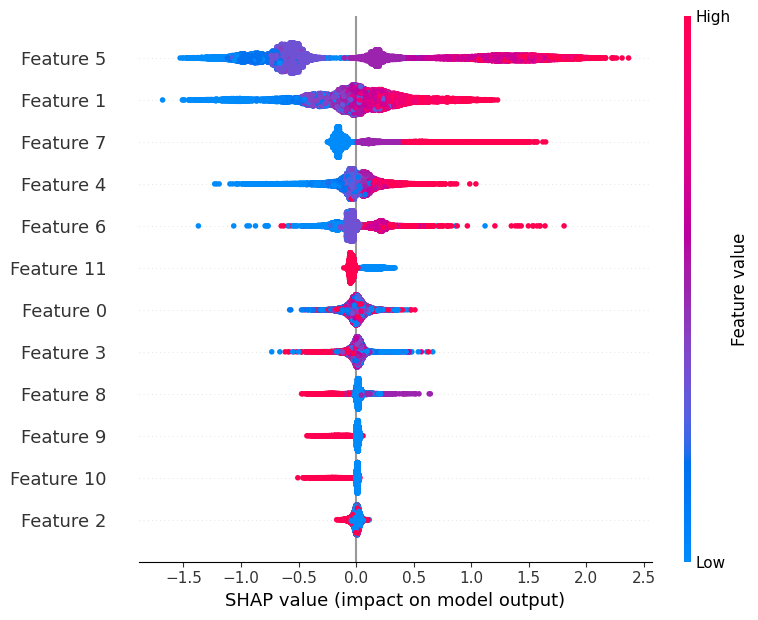

In [21]:
if 'HAS_SHAP' in globals() and HAS_SHAP:
    try:
        import shap, numpy as np
        # Preprocess test for xgb pipeline
        if hasattr(xgb_clf.named_steps["pre"], "transform"):
            X_test_proc = xgb_clf.named_steps["pre"].transform(X_test)
        else:
            X_test_proc = X_test.values
        booster = xgb_clf.named_steps["clf"]
        explainer = shap.TreeExplainer(booster)
        shap_values = explainer.shap_values(X_test_proc, check_additivity=False)
        shap.summary_plot(shap_values, X_test_proc, show=False)
    except Exception as e:
        print("SHAP skipped due to:", e)
else:
    print("SHAP not available; skipping.")

## 11) Ghi chú chọn mô hình & bảng so sánh

- **XGBoost (native missing)** thường là lựa chọn đầu tiên cho tabular + thiếu dữ liệu.
- **RF (missing-aware)** giữ tín hiệu thiếu dữ liệu tốt hơn so với mean-impute thuần.
- **LR** là baseline nhanh và dễ giải thích.  
- **TabNet / FT-Transformer**: chạy khi có GPU và dữ liệu lớn hơn; notebook sẽ **tự bỏ qua** nếu không cài được.

| Model | Loại | Ưu điểm | Nhược điểm | Thời gian train | Explainability |
|---|---|---|---|---|---|
| Logistic Regression | Linear | Nhanh, dễ giải thích | Yếu với quan hệ phi tuyến | Rất nhanh | ⭐⭐⭐⭐⭐ |
| Random Forest | Tree ensemble | Mạnh, robust | Model nặng, inference chậm | Trung bình | ⭐⭐⭐ |
| XGBoost | Gradient boosting | Hiệu năng cao, phổ biến | Cần tuning | Trung bình | ⭐⭐ |
| TabNet | Deep learning tabular | Representation tốt | Cần GPU, khó train | Chậm | ⭐⭐ |
| FT-Transformer | Transformer tabular | Hợp với multimodal | Cần nhiều data | Chậm | ⭐ |

**Decision Tree & missing values:** Cây quyết định hiện đại (XGBoost/LightGBM) gán nhánh cho **NaN** trong lúc học, coi thiếu dữ liệu là **tín hiệu**; vì vậy tốt hơn so với điền trung bình rồi học. Với sklearn trees, ta mô phỏng bằng **MissingIndicator** và 'Missing' cho biến phân loại.

In [22]:
import joblib

joblib.dump(xgb_clf, "xgboost_model.pkl")

print("✅ Saved model to xgboost_model.pkl")


✅ Saved model to xgboost_model.pkl
